# Imports

In [1]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoProcessor, Llama4ForConditionalGeneration, default_data_collator, get_linear_schedule_with_warmup
from peft import get_peft_config, get_peft_model, get_peft_model_state_dict, PrefixTuningConfig
from datasets import load_dataset, Dataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm, trange
import torch
import os
import pandas as pd
import numpy as np

# Parameters

In [67]:
# load csv from data/MELD
raw_train_df = pd.read_csv("data/MELD/train_sent_emo.csv")
raw_valid_df = pd.read_csv("data/MELD/dev_sent_emo.csv")
raw_test_df = pd.read_csv("data/MELD/test_sent_emo.csv")

#take only Utterance and Emotion columns
train_df = raw_train_df[['Dialogue_ID', 'Utterance', 'Emotion']]
valid_df = raw_valid_df[['Dialogue_ID', 'Utterance', 'Emotion']]
test_df = raw_test_df[['Dialogue_ID', 'Utterance', 'Emotion']]



model_name_or_path = "t5-base"
tokenizer_name_or_path = "t5-base"

num_virtual_tokens = 20
max_length = 256

do_train = True
do_eval = True

lr = 1e-4
warmup_ratio=0.1
weight_decay=0.01
num_epochs = 5
batch_size = 8
logging_steps=625
eval_steps=625
save_steps=625
# logging_steps=60
# eval_steps=60
# save_steps=60
dataset_name = "MELD"
output_dir = f"results/{dataset_name}/{model_name_or_path.split('/')[-1]}-peft/lr_{lr}-epochs_{num_epochs}-batch_{batch_size}"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_subjects = len(raw_train_df['Emotion'].unique())+1
peft_padding_id = num_subjects*num_virtual_tokens


# integrate model class with dataset

## AbstractPrompt Classes

In [3]:
from peft import PeftModelForSeq2SeqLM, PeftConfig, PromptEncoderReparameterizationType, PromptEncoderConfig
from peft.tuners.prefix_tuning import PrefixEncoder
from peft.tuners.p_tuning import PromptEncoder
from peft.utils import _get_batch_size, TRANSFORMERS_MODELS_TO_PREFIX_TUNING_POSTPROCESS_MAPPING, map_cache_to_layer_device_map, PeftType, TaskType
from transformers import PreTrainedModel, DynamicCache, EncoderDecoderCache
from typing import Optional
import torch
import numpy as np
import warnings
from dataclasses import dataclass, field
import enum
from peft.mapping import MODEL_TYPE_TO_PEFT_MODEL_MAPPING
from typing import Union, List, Dict, Any


@dataclass
class AbstractPromptEncoderConfig(PromptEncoderConfig):
    """
    This is the configuration class to store the configuration of a [`PromptEncoder`].

    Args:
        encoder_reparameterization_type (Union[[`PromptEncoderReparameterizationType`], `str`]):
            The type of reparameterization to use.
        encoder_hidden_size (`int`): The hidden size of the prompt encoder.
        encoder_num_layers (`int`): The number of layers of the prompt encoder.
        encoder_dropout (`float`): The dropout probability of the prompt encoder.
    """

    num_subjects: int = field(
        default=8,
        metadata={"help": "The number of subjects of the prompt encoder"},
    )
    padding_idx: int = field(
        default=None,
        metadata={"help": "The padding index of the prompt encoder"},
    )
    def __post_init__(self):
        super().__post_init__()
        self.peft_type = PeftType.AP_Tuning


class AbstractPromptEncoder(PromptEncoder):
    def __init__(self, config):
        super().__init__(config)
        self.num_subjects = config.num_subjects
        self.total_virtual_tokens = config.num_virtual_tokens * config.num_subjects * config.num_transformer_submodules
        if config.padding_idx is not None:
            self.padding_idx = config.padding_idx
        else:
            self.padding_idx = self.total_virtual_tokens
            self.total_virtual_tokens += 1

        # embedding
        self.embedding = torch.nn.Embedding(self.total_virtual_tokens, self.token_dim, padding_idx=self.padding_idx)
        if not config.inference_mode:
            if self.encoder_type == PromptEncoderReparameterizationType.LSTM:
                lstm_dropout = config.encoder_dropout
                num_layers = config.encoder_num_layers
                # LSTM
                self.lstm_head = torch.nn.LSTM(
                    input_size=self.input_size,
                    hidden_size=self.hidden_size,
                    num_layers=num_layers,
                    dropout=lstm_dropout,
                    bidirectional=True,
                    batch_first=True,
                )

                self.mlp_head = torch.nn.Sequential(
                    torch.nn.Linear(self.hidden_size * 2, self.hidden_size * 2),
                    torch.nn.ReLU(),
                    torch.nn.Linear(self.hidden_size * 2, self.output_size),
                )

            elif self.encoder_type == PromptEncoderReparameterizationType.MLP:
                encoder_num_layers_default = PromptEncoderConfig.encoder_num_layers
                if config.encoder_num_layers != encoder_num_layers_default:
                    warnings.warn(
                        f"for {self.encoder_type.value}, the argument `encoder_num_layers` is ignored. "
                        f"Exactly {encoder_num_layers_default} MLP layers are used."
                    )
                layers = [
                    torch.nn.Linear(self.input_size, self.hidden_size),
                    torch.nn.ReLU(),
                    torch.nn.Linear(self.hidden_size, self.hidden_size),
                    torch.nn.ReLU(),
                    torch.nn.Linear(self.hidden_size, self.output_size),
                ]
                self.mlp_head = torch.nn.Sequential(*layers)

            else:
                raise ValueError("Prompt encoder type not recognized. Please use one of MLP (recommended) or LSTM.")


class AbstractPeftModelForSeq2SeqLM(PeftModelForSeq2SeqLM):
    def __init__(self, model: torch.nn.Module, peft_config: PeftConfig, adapter_name: str = "default", **kwargs):
        super().__init__(model, peft_config, adapter_name, **kwargs)
        self.model = model
        # self.peft_config = peft_config

    def _setup_prompt_encoder(self, adapter_name: str):
        config = self.peft_config[adapter_name]
        if not hasattr(self, "prompt_encoder"):
            self.prompt_encoder = torch.nn.ModuleDict({})
            self.prompt_tokens = {}
        transformer_backbone = None
        for name, module in self.base_model.named_children():
            for param in module.parameters():
                param.requires_grad = False
            if isinstance(module, PreTrainedModel):
                # Make sure to freeze Tranformers model
                if transformer_backbone is None:
                    transformer_backbone = module
                    self.transformer_backbone_name = name
        if transformer_backbone is None:
            transformer_backbone = self.base_model

        if config.num_transformer_submodules is None:
            config.num_transformer_submodules = 2 if config.task_type in [TaskType.SEQ_2_SEQ_LM, TaskType.ABS_SEQ_2_SEQ_LM] else 1

        # determine the word embeddings
        word_embeddings = None
        try:
            # First try to find the word embeddings based on the module name, this should work for models like Bert,
            # Roberta, Deberta, etc.
            word_embeddings = self.base_model.get_submodule("embeddings.word_embeddings")
        except AttributeError:
            pass

        if word_embeddings is None:
            # Word embeddings could not be determined. Next try to guess them by checking which parameter has the size
            # of the vocab.
            for named_param, value in list(transformer_backbone.named_parameters()):
                # for ZeRO-3, the tensor is sharded across accelerators and deepspeed modifies it to a tensor with shape
                # [0] the actual unsharded shape is stored in "ds_shape" attribute special handling is needed in case
                # the model is initialized in deepspeed.zero.Init() context or HfDeepSpeedConfig has been called before
                # For reference refer to issue: https://github.com/huggingface/peft/issues/996
                deepspeed_distributed_tensor_shape = getattr(value, "ds_shape", None)

                if value.shape[0] == self.base_model.config.vocab_size or (
                    deepspeed_distributed_tensor_shape is not None
                    and deepspeed_distributed_tensor_shape[0] == self.base_model.config.vocab_size
                ):
                    word_embeddings = transformer_backbone.get_submodule(named_param.replace(".weight", ""))
                    break

        self.word_embeddings = word_embeddings

        prompt_encoder = AbstractPromptEncoder(config)

        prompt_encoder = prompt_encoder.to(self.device)
        self.prompt_encoder.update(torch.nn.ModuleDict({adapter_name: prompt_encoder}))
        
        self.prompt_tokens[adapter_name] = torch.arange(
            config.num_virtual_tokens * config.num_subjects * config.num_transformer_submodules
        ).long()

    def get_prompt(self, batch_size: int, object_ids: Optional[torch.Tensor] = None, object_tokens: Optional[torch.Tensor] = None) -> torch.Tensor:
        """
        Returns the virtual prompts to use for Peft. Only applicable when using a prompt learning method.

        The object_ids should be a tensor of shape 
        """
        peft_config = self.active_peft_config
        prompt_encoder = self.prompt_encoder[self.active_adapter]
        # arrange the prompt tokens according to the object id
        if object_tokens is not None:
            prompt_tokens = object_tokens
        elif object_ids is not None:
            object_ids = object_ids.view(batch_size, -1)
            prompt_tokens = (object_ids * peft_config.num_virtual_tokens)[:, :, None] + np.arange(peft_config.num_virtual_tokens)
            # set token id to padding id if it is out of range
            prompt_tokens[prompt_tokens > prompt_encoder.padding_idx] = prompt_encoder.padding_idx
            
        else:
            raise ValueError("object_ids is None, please provide object_ids for AbstractPeftModelForSeq2SeqLM")
        

        if peft_config.inference_mode:
            # prompts = prompt_encoder.embedding.weight
            # TODO: add support for inference mode
            pass
        else:
            prompts = prompt_encoder(prompt_tokens) # (batch_size, num_virtual_tokens, hidden_size)
        return prompts
    
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        inputs_embeds=None,
        decoder_input_ids=None,
        decoder_attention_mask=None,
        decoder_inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
        object_tokens=None,

        **kwargs,
    ):
        """
        args:
        object_ids: (batch_size, num_subjects) tensor of object ids. The object ids are used to select the prompt tokens. Not implemented
        object_tokens: (batch, lengths) tensor of object tokens. The object tokens are used to generate the prompt tokens. Should be the same length as prompt tokens.
        """
        peft_config = self.active_peft_config
        batch_size = _get_batch_size(input_ids, inputs_embeds)
        if decoder_attention_mask is not None:
            # concat prompt attention mask
            prefix_attention_mask = torch.ones(batch_size, peft_config.num_virtual_tokens).to(
                decoder_attention_mask.device
            )
            if peft_config.peft_type not in [PeftType.PROMPT_TUNING, PeftType.P_TUNING]:
                decoder_attention_mask = torch.cat((prefix_attention_mask, decoder_attention_mask), dim=1)

        if kwargs.get("position_ids", None) is not None:
            warnings.warn("Position ids are not supported for parameter efficient tuning. Ignoring position ids.")
            kwargs["position_ids"] = None
        if kwargs.get("token_type_ids", None) is not None:
            warnings.warn("Token type ids are not supported for parameter efficient tuning. Ignoring token type ids")
            kwargs["token_type_ids"] = None
        kwargs.update(
            {
                "attention_mask": attention_mask,
                "decoder_attention_mask": decoder_attention_mask,
                "labels": labels,
                "output_attentions": output_attentions,
                "output_hidden_states": output_hidden_states,
                "return_dict": return_dict,
            }
        )

        if inputs_embeds is None:
            inputs_embeds = self.word_embeddings(input_ids)

        prompts = self.get_prompt(batch_size=batch_size, object_tokens=object_tokens)
        prompts = prompts.to(inputs_embeds.dtype)

        if inputs_embeds.dim()==3:
            # inputs_embeds: (batch_size, sequence_len, hidden_size)
            # prompts: (batch_size, sequence_len, hidden_size)
            inputs_embeds = inputs_embeds+prompts

        return self.base_model(
            inputs_embeds=inputs_embeds,
            decoder_input_ids=decoder_input_ids,
            decoder_inputs_embeds=decoder_inputs_embeds,
            **kwargs,
        )
    

MODEL_TYPE_TO_PEFT_MODEL_MAPPING["ABS_SEQ_2_SEQ_LM"]=AbstractPeftModelForSeq2SeqLM

In [4]:


peft_config = AbstractPromptEncoderConfig(task_type=TaskType.ABS_SEQ_2_SEQ_LM, inference_mode=False, num_virtual_tokens=20, num_subjects=num_subjects)

model = AutoModelForSeq2SeqLM.from_pretrained(model_name_or_path)
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 2,018,304 || all params: 224,921,856 || trainable%: 0.8973


# Create next token prediction dataset

In [5]:
# length of the dataset
print(f"train_df: {len(raw_train_df)}")
# check the label types in Emotion
print(raw_train_df['Emotion'].unique())
raw_train_df

train_df: 9989
['neutral' 'surprise' 'fear' 'sadness' 'joy' 'disgust' 'anger']


,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,also I was the point person on my company’s tr...,Chandler,neutral,neutral,0,0,8,21,"00:16:16,059","00:16:21,731"
1,2,You must’ve had your hands full.,The Interviewer,neutral,neutral,0,1,8,21,"00:16:21,940","00:16:23,442"
2,3,That I did. That I did.,Chandler,neutral,neutral,0,2,8,21,"00:16:23,442","00:16:26,389"
3,4,So let’s talk a little bit about your duties.,The Interviewer,neutral,neutral,0,3,8,21,"00:16:26,820","00:16:29,572"
4,5,My duties? All right.,Chandler,surprise,positive,0,4,8,21,"00:16:34,452","00:16:40,917"
...,...,...,...,...,...,...,...,...,...,...,...
9984,10474,You or me?,Chandler,neutral,neutral,1038,13,2,3,"00:00:48,173","00:00:50,799"
9985,10475,"I got it. Uh, Joey, women don't have Adam's ap...",Ross,neutral,neutral,1038,14,2,3,"00:00:51,009","00:00:53,594"
9986,10476,"You guys are messing with me, right?",Joey,surprise,positive,1038,15,2,3,"00:01:00,518","00:01:03,520"
9987,10477,Yeah.,All,neutral,neutral,1038,16,2,3,"00:01:05,398","00:01:07,274"


## Tokenize the data

In [47]:
text_column = "Utterance"
label_column = "Emotion"

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
emotion_name_to_id = {name:i for i, name in enumerate(raw_train_df['Emotion'].unique())}
emotion_id_to_name = {i:name for i, name in enumerate(raw_train_df['Emotion'].unique())}
emotion_token_to_id = {tuple(tokenizer(name)["input_ids"]):i for i, name in enumerate(raw_train_df['Emotion'].unique())}
# tokenizer(emotion_id_to_name[emotions[j]])["input_ids"]
query_id = len(emotion_name_to_id)

def tokenize_function(examples):
    # print(examples)
    utterance = examples[text_column]
    emotion = examples[label_column]
    utterance_id = tokenizer(utterance, max_length=max_length, padding=False, truncation=False, return_tensors="pt")["input_ids"].view(-1)
    emotion_id = emotion_name_to_id[emotion]
    
    return {"Dialogue_ID":examples["Dialogue_ID"], "UtteranceID": utterance_id, "EmotionID": emotion_id}
    
dialogue_train_df = train_df.apply(
    tokenize_function,
    axis=1,
    result_type="expand",
)
dialogue_train_df = dialogue_train_df.groupby('Dialogue_ID').agg(list).reset_index()

dialogue_eval_df = valid_df.apply(
    tokenize_function,
    axis=1,
    result_type="expand",
)
dialogue_eval_df = dialogue_eval_df.groupby('Dialogue_ID').agg(list).reset_index()


## dataset transformation function

In [61]:

def dialogue_process_function(dialogue_data, utterance_name="UtteranceID", emotion_name="EmotionID", max_length=None, utterance_padding_token_id=0, emotion_padding_token_id=160, query_id=7, num_virtual_tokens=20):
    # print(examples)
    utterances_data = dialogue_data[utterance_name]
    emotions_data = dialogue_data[emotion_name]
    
    if max_length is None:
        max_length=0
        for utts in utterances_data:
            length = 0
            for utt in utts:
                length += utt.shape[-1]+num_virtual_tokens
            if length > max_length:
                max_length = length
    print(f"max_length: {max_length}")

    output = {
            "UtteranceID": [],
            "EmotionID": [],
            "AttentionMask": [],
            "Label": [],
        }
    
    for i, utterances in enumerate(tqdm(utterances_data)):
        emotions = emotions_data[i]
        begin_idx = 0
        last_utterance_unpad=None
        for j, utterance in enumerate(utterances):
            
            # print(f"data: {i}, utterance: {j}, begin_idx: {begin_idx}")

            new_utterance = torch.cat([ torch.full((num_virtual_tokens,), utterance_padding_token_id, dtype=torch.long), 
                                        utterance], dim=0) # preserve space for virtual tokens

            if new_utterance.shape[-1] > max_length or last_utterance_unpad is None:
                output_utterance = new_utterance[..., :max_length] # truncation
                begin_idx = j
            else:
                current_length = last_utterance_unpad.shape[-1] + new_utterance.shape[-1]
                length_to_trim = 0
                while current_length-length_to_trim > max_length:
                    length_to_trim += min(utterances[begin_idx].shape[-1]+num_virtual_tokens, max_length)
                    begin_idx+=1
                output_utterance = torch.cat([last_utterance_unpad[..., length_to_trim:], new_utterance], dim=0)
            output_attention_mask = torch.ones((output_utterance.shape[-1],), dtype=torch.long)
            last_utterance_unpad = output_utterance
            # pad the rest of the sequence
            output_utterance = torch.cat([output_utterance, torch.full((max_length - output_utterance.shape[-1],), utterance_padding_token_id, dtype=torch.long)], dim=0)
            output_attention_mask = torch.cat([output_attention_mask, torch.zeros((max_length - output_attention_mask.shape[-1],), dtype=torch.long)], dim=0)


            
            emotion = torch.tensor(emotions[begin_idx:j]+[query_id])
            output_label = tokenizer(emotion_id_to_name[emotions[j]])["input_ids"]

            prompt_tokens = (emotion * num_virtual_tokens).unsqueeze(-1).view(-1,1) + np.arange(num_virtual_tokens) if emotions[begin_idx:j] else torch.tensor([])

            # concatenate the prompt tokens and pad them in between to match the length of the utterance
            output_emotion = torch.tensor([])
            emotion_idx = begin_idx
            padding_max_length = max_length-num_virtual_tokens
            for pt in prompt_tokens:
                pt = torch.cat([pt, torch.full((min(utterances[emotion_idx].shape[-1], padding_max_length),), emotion_padding_token_id, dtype=torch.long)], dim=0)
                output_emotion = torch.cat([output_emotion, pt], dim=0)
                emotion_idx+=1
            # set token id to padding id if it is out of range
            output_emotion[output_emotion > emotion_padding_token_id] = emotion_padding_token_id
            output_prompt = torch.cat([output_emotion, torch.full((max_length - output_emotion.shape[-1],), emotion_padding_token_id, dtype=torch.long)], dim=0)
            output_prompt = output_prompt.to(torch.long)

            # if output_utterance.shape[-1] != max_length or output_emotion.shape[-1] != max_length, raise ValueError
            if output_utterance.shape[-1] != max_length:
                raise ValueError(f"output_utterance shape: {output_utterance.shape[-1]} != max_length: {max_length}")
            if output_prompt.shape[-1] != max_length:
                raise ValueError(f"output_emotion shape: {output_prompt.shape[-1]} != max_length: {max_length}")

            output["UtteranceID"].append(output_utterance)
            output["EmotionID"].append(output_prompt)
            output["AttentionMask"].append(output_attention_mask)
            output["Label"].append(output_label)
    return output


utterance_padding_token_id = tokenizer.pad_token_id
emotion_padding_token_id = model.prompt_encoder["default"].padding_idx

dialogue_train_df_processed = dialogue_process_function(dialogue_train_df, max_length=max_length, utterance_padding_token_id=utterance_padding_token_id, emotion_padding_token_id=emotion_padding_token_id, query_id=query_id, num_virtual_tokens=num_virtual_tokens)
dialogue_train_df_processed = Dataset.from_dict(dialogue_train_df_processed).with_format("torch")
dialogue_eval_df_processed = dialogue_process_function(dialogue_eval_df, max_length=max_length, utterance_padding_token_id=utterance_padding_token_id, emotion_padding_token_id=emotion_padding_token_id, query_id=query_id, num_virtual_tokens=num_virtual_tokens)
dialogue_eval_df_processed = Dataset.from_dict(dialogue_eval_df_processed).with_format("torch")


train_dataloader = DataLoader(
    dataset=dialogue_train_df_processed,
    batch_size=batch_size,
    shuffle=True,
    # collate_fn=default_data_collator,
)
eval_dataloader = DataLoader(
    dataset=dialogue_eval_df_processed,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=default_data_collator,
)


max_length: 256


  0%|          | 0/1038 [00:00<?, ?it/s]

C:\Users\cheng\AppData\Local\Temp\ipykernel_12484\2084052472.py:55: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  prompt_tokens = (emotion * num_virtual_tokens).unsqueeze(-1).view(-1,1) + np.arange(num_virtual_tokens) if emotions[begin_idx:j] else torch.tensor([])


max_length: 256


  0%|          | 0/114 [00:00<?, ?it/s]

In [85]:
# check the proportion of each label
num_labels={tokens:0 for tokens in emotion_token_to_id}
for data in dialogue_train_df_processed:
    label = tuple(data["Label"].tolist())
    num_labels[label]+=1

for tokens in num_labels:
    name = emotion_id_to_name[emotion_token_to_id[tokens]]
    print(f"{name}: {num_labels[tokens]} ({num_labels[tokens]*100/len(dialogue_train_df_processed)}%)")

neutral: 4710 (47.15186705375913%)
surprise: 1205 (12.063269596556212%)
fear: 268 (2.682951246371008%)
sadness: 683 (6.837521273400741%)
joy: 1743 (17.44919411352488%)
disgust: 271 (2.7129842827109822%)
anger: 1109 (11.102212433677044%)


# Train

In [9]:
# # training with huggingface trainer
# # not applicable, as we need input for prompt encoder
# from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
# output_dir = f"results/{model_name_or_path.split('/')[-1]}-peft/lr_{lr}-epochs_{num_epochs}-batch_{batch_size}"
# training_args = Seq2SeqTrainingArguments(
#     output_dir=output_dir,
#     do_train=do_train,
#     do_eval=do_eval,

#     per_device_train_batch_size=batch_size,
#     per_device_eval_batch_size=batch_size,
#     learning_rate=lr,
#     warmup_ratio=warmup_ratio,
#     weight_decay=weight_decay,
#     num_train_epochs=num_epochs,
    
#     logging_strategy="steps",
#     logging_steps=logging_steps,
#     eval_strategy="steps",
#     eval_steps = eval_steps,
#     save_strategy="steps",
#     save_steps=save_steps,
#     save_total_limit=2,

#     predict_with_generate=True,
#     load_best_model_at_end=True,
# )
# trainer = Seq2SeqTrainer(
#     model=model,
#     args=training_args,
#     train_dataset=dialogue_train_df_processed,
#     eval_dataset=dialogue_eval_df_processed,
#     tokenizer=tokenizer,
#     data_collator=default_data_collator,
# )


In [ ]:
# setup custom training loop
output_dir = f"results/{model_name_or_path.split('/')[-1]}-peft/lr_{lr}-epochs_{num_epochs}-batch_{batch_size}"
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
num_training_steps = num_epochs * len(train_dataloader)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(num_training_steps * warmup_ratio),
    num_training_steps=num_training_steps,
)
# move model to device
model.to(device)
# training loop
model.train()
cur_step = 0
best_F1_score = 0
train_loss_list = []
eval_loss_list = []
eval_F1_score_list = []
for epoch in trange(num_epochs, desc=" epoch loop", position=0):
    for batch in tqdm(train_dataloader, desc=" inner loop", position=1, leave=False):
        # move batch to device
        batch = {k: v.to(device) for k, v in batch.items() if isinstance(v, torch.Tensor)}
        # forward pass
        outputs = model(
            input_ids=batch["UtteranceID"],
            attention_mask=batch["AttentionMask"],
            object_tokens=batch["EmotionID"],
            labels=batch["Label"],
        )
        loss = outputs.loss
        print(loss)
        # backward pass
        loss.backward()
        # update parameters
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        train_loss_list.append(loss.item())

        # if cur_step % logging_steps == 0:
        #     print(f"Step {cur_step}, Loss: {loss.item()}")


        # evaluation
        if do_eval and cur_step % eval_steps == eval_steps - 1:
            model.eval()
            # calculate the macro F1 score

            eval_loss = 0.0
            num_prediction = {label_id: 0 for label_id in range(len(emotion_token_to_id))}
            num_label = {label_id: 0 for label_id in range(len(emotion_token_to_id))}
            num_true_positive = {label_id: 0 for label_id in range(len(emotion_token_to_id))}

            for eval_batch in tqdm(eval_dataloader, desc="Eval loop", position=2, leave=False):
                eval_batch = {k: v.to(device) for k, v in eval_batch.items() if isinstance(v, torch.Tensor)}
                with torch.no_grad():
                    eval_outputs = model(
                        input_ids=eval_batch["UtteranceID"],
                        attention_mask=eval_batch["AttentionMask"],
                        object_tokens=eval_batch["EmotionID"],
                        labels=eval_batch["Label"],
                    )
                    eval_loss += eval_outputs.loss.item()

                # calculate precision and recall
                eval_predictions = eval_outputs.logits.argmax(dim=-1).tolist()
                eval_labels = eval_batch["Label"].tolist()
                # print(eval_outputs["logits"].shape)
                # print(eval_predictions)
                # print(eval_labels)

                # sweep through the predictions and labels
                for i in range(len(eval_predictions)):
                    pred = tuple(eval_predictions[i])
                    label = tuple(eval_labels[i])
                    if pred in emotion_token_to_id:
                        num_prediction[emotion_token_to_id[pred]] += 1
                    num_label[emotion_token_to_id[label]] += 1
                    if pred == label:
                        num_true_positive[emotion_token_to_id[pred]] += 1
            recall = {label_id: num_true_positive[label_id] / num_label[label_id] if num_label[label_id] > 0 else 0 for label_id in range(len(emotion_token_to_id))}
            precision = {label_id: num_true_positive[label_id] / num_prediction[label_id] if num_prediction[label_id] > 0 else 0 for label_id in range(len(emotion_token_to_id))}
            F1_score = {label_id: 2 * precision[label_id] * recall[label_id] / (precision[label_id] + recall[label_id]) if (precision[label_id] + recall[label_id]) > 0 else 0 for label_id in range(len(emotion_token_to_id))}
            macro_F1_score = np.mean(list(F1_score.values()))
            print(f"cur_step: {cur_step+1}")
            print("  loss:", eval_loss / len(eval_dataloader))
            print("  recall:", recall)
            print("  precision:", precision)
            print("  F1_score:", F1_score)
            print("  macro_F1_score:", macro_F1_score)
            print("==========================================================================================")
            eval_loss_list.append(eval_loss / len(eval_dataloader))
            eval_F1_score_list.append(macro_F1_score)

            # save the model if the F1 score is better than the best F1 score
            if macro_F1_score > best_F1_score:
                best_F1_score = macro_F1_score
                model.save_pretrained(output_dir)
                tokenizer.save_pretrained(output_dir)
                print(f"Model saved to {output_dir} with F1 score: {best_F1_score}")

            model.train()

        cur_step += 1



 epoch loop:   0%|          | 0/5 [00:00<?, ?it/s]

 inner loop:   0%|          | 0/1249 [00:00<?, ?it/s]

tensor(0.7076, device='cuda:0', grad_fn=<NllLossBackward0>)


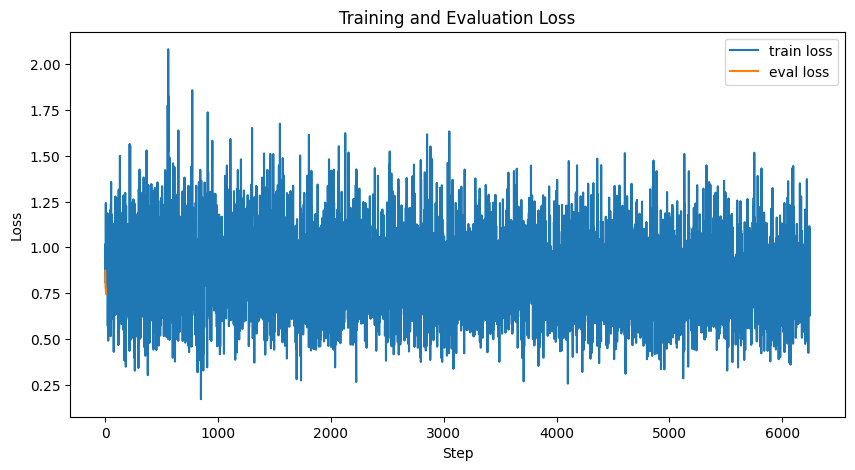

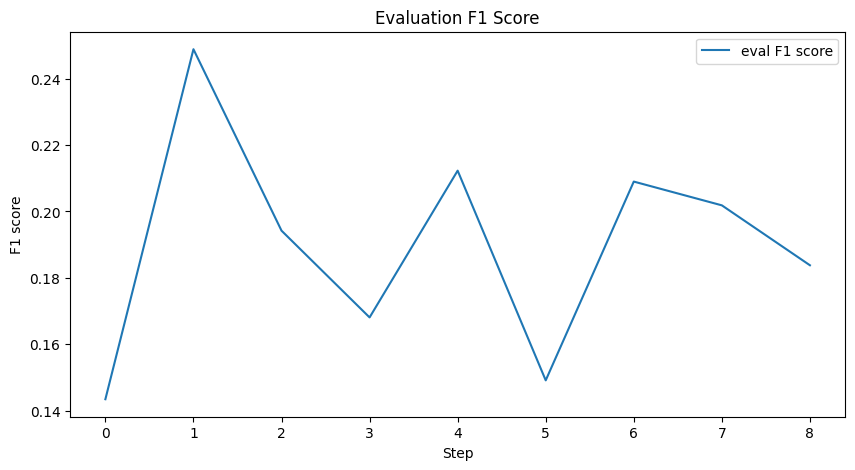

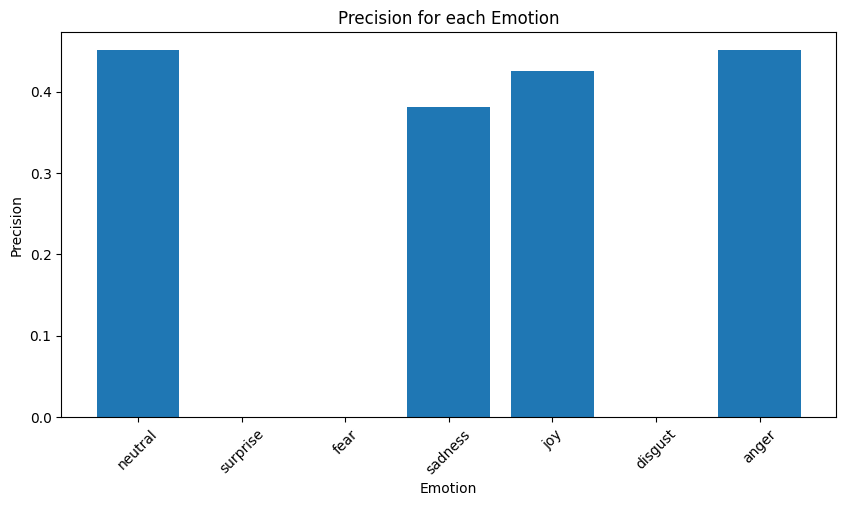

In [ ]:
# draw the training and evaluation loss
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(train_loss_list, label="train loss")
plt.plot(eval_loss_list, label="eval loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training and Evaluation Loss")
plt.legend()
plt.show()

# draw the evaluation F1 score
plt.figure(figsize=(10, 5))
plt.plot(eval_F1_score_list, label="eval F1 score")
plt.xlabel("Step")
plt.ylabel("F1 score")
plt.title("Evaluation F1 Score")
plt.legend()
plt.show()


# ProgressiveDialogueDataset Class (not used for now)

In [ ]:
from torch.utils.data import Dataset, DataLoader
import bisect


class ProgressiveDialogueDataset(Dataset):
    def __init__(self, dialogue_data, utterance_name="UtteranceID", emotion_name="EmotionID", max_length=None, utterance_padding_token_id=0, query_id=7, num_virtual_tokens=20):
        """
        Args:
            dialogue_data: A list of lists, where each inner list contains sentences
                           from one dialogue.
        """
        self.utterances = dialogue_data[utterance_name]
        self.emotions = dialogue_data[emotion_name]

        if max_length is None:
            max_length=0
            for utts in self.utterances:
                length = 0
                for utt in utts:
                    length += utt.shape[-1]+num_virtual_tokens
                if length > max_length:
                    max_length = length
        self.max_length = max_length

        self.query_id = query_id
        self.utterance_padding_token_id = utterance_padding_token_id
        self.num_virtual_tokens = num_virtual_tokens


        self.cumulative_sentence_counts = []
        self.row_lengths = [len(row) for row in self.utterances]
        self.total_sentences = 0
        for length in self.row_lengths:
            self.total_sentences += length
            self.cumulative_sentence_counts.append(self.total_sentences)

    def __len__(self):
        return self.total_sentences

    def __getitem__(self, idx):

        # Find which row this index belongs to
        row_index = bisect.bisect_right(self.cumulative_sentence_counts, idx)

        # Find the index of the sentence within that row
        sentence_index = idx - self.cumulative_sentence_counts[row_index]

        # Get the progressive sequence of sentences, save space for virtual tokens and concatenate every sentence
        utterances = self.utterances[row_index][:sentence_index + 1]
        utterance_lengths = [utt.shape[-1] for utt in utterances]

        # calculate the desired length of the utterance
        begin_index = len(utterance_lengths)
        cumulative_length = 0
        for i in range(len(utterance_lengths)-1,0-1, -1):
            # add virtual token space to the beginning of the sentence
            utterances[i] = torch.cat([ torch.full((self.num_virtual_tokens,), self.utterance_padding_token_id, dtype=torch.long), 
                                        utterances[i]], dim=1)
            cumulative_length += utterance_lengths[i]+self.num_virtual_tokens
            if cumulative_length > self.max_length:
                break
            begin_index = i
        # concatenate the sentences
        if begin_index == len(utterance_lengths):
            # if the first sentence is too long, we need to truncate it
            utterance = utterances[-1][:self.max_length]
            emotions = [self.query_id]
            attention_mask = torch.ones((self.max_length,), dtype=torch.long)

        else:
            utterance = torch.cat(utterances[begin_index:], dim=1)
            emotions = self.emotions[row_index][begin_index:sentence_index]
            emotions = emotions + [self.query_id]
            attention_mask = torch.ones((utterance.shape[-1],), dtype=torch.long)
            attention_mask = torch.cat([attention_mask, torch.zeros((self.max_length - utterance.shape[-1],), dtype=torch.long)], dim=1)
            utterance = torch.cat([utterance, torch.full((self.max_length - utterance.shape[-1],), self.utterance_padding_token_id, dtype=torch.long)], dim=1)

        labels = self.emotions[row_index][sentence_index]

        return {
            "UtteranceID": utterance,
            "EmotionID": emotions,
            "AttentionMask": attention_mask,
            "Label": labels,
        }




# T5-Large

## train

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=(len(train_dataloader) * num_epochs),
)

In [ ]:
model = model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for step, batch in enumerate(tqdm(train_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.detach().float()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

    model.eval()
    eval_loss = 0
    eval_preds = []
    for step, batch in enumerate(tqdm(eval_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        loss = outputs.loss
        eval_loss += loss.detach().float()
        eval_preds.extend(
            tokenizer.batch_decode(torch.argmax(outputs.logits, -1).detach().cpu().numpy(), skip_special_tokens=True)
        )

    eval_epoch_loss = eval_loss / len(eval_dataloader)
    eval_ppl = torch.exp(eval_epoch_loss)
    train_epoch_loss = total_loss / len(train_dataloader)
    train_ppl = torch.exp(train_epoch_loss)
    print(f"{epoch=}: {train_ppl=} {train_epoch_loss=} {eval_ppl=} {eval_epoch_loss=}")

In [ ]:
correct = 0
total = 0
for pred, true in zip(eval_preds, dataset["validation"]["text_label"]):
    if pred.strip() == true.strip():
        correct += 1
    total += 1
accuracy = correct / total * 100
print(f"{accuracy=} % on the evaluation dataset")
print(f"{eval_preds[:10]=}")
print(f"{dataset['validation']['text_label'][:10]=}")

# Llama-4

In [ ]:
# Apply prefix tuning to solve the emotion recognition task
# First, do the language modeling task with prefix tuning
# The prefix are the emotions in the dataset, and the model will learn to predict the next word based on the prefix
# There's also an additional prefix for answering the emotion recognition task.


model_id = "meta-llama/Llama-4-Scout-17B-16E-Instruct"

processor = AutoProcessor.from_pretrained(model_id)
model = Llama4ForConditionalGeneration.from_pretrained(
    model_id,
    attn_implementation="flex_attention",
    device_map="auto",
    torch_dtype=torch.bfloat16,
)
messages = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": train_df["Emotion"][0]},
            {"type": "text", "text": train_df["Utterance"][0]},
        ]
    },
]
inputs = processor.apply_chat_template(
    messages,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt",
)
# def get_data_loader(df, processor, max_length=128, batch_size=4):
#     """
#     Create a DataLoader for the dataset.
#     """
#     def encode(examples):
#         return processor(
#             examples["Emotion"],
#             examples["Utterance"],
#             truncation=True,
#             max_length=max_length,
#             padding="max_length",
#         )

#     # Encode the dataset
#     encoded_dataset = df.apply(encode, axis=1).tolist()
    
#     # Create DataLoader
#     data_loader = DataLoader(
#         encoded_dataset,
#         batch_size=batch_size,
#         collate_fn=default_data_collator
#     )
    
#     return data_loader

